In [1]:
# !pip install wordcloud scikit-network datasets
# !pip install tiktoken openai transformers sentence_transformers

# !pip install -U 'spacy[apple]'
# # !pip install -U 'spacy[cuda12x]'

In [2]:
import os
from dotenv import load_dotenv; load_dotenv()

from tqdm.notebook import tqdm
import pickle
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from datasets import load_dataset

os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
import torch
import spacy; spacy.prefer_gpu()
import tiktoken
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# from vertexai.preview import tokenization
from transformers import pipeline, AutoTokenizer, AutoModel, AutoModelForTokenClassification
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

import networkx as nx
from transformers.pipelines import pipeline

from src.helpers import preprocessing as preproc
from src.helpers import postprocessing as postproc
from src.helpers.sentiment_analysis import SentimentModel
from src.topol_modeling import TopolModeling as TOPOL
from src.openai_api import OPENAI_CLIENT, OpenAIEmbedding
from src.google_ai_api import GGENAI_CLIENT, GoogleAIEmbedding, AdvancedGoogleAIEmbedding

/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/tig1/miniforge3/envs/topol/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/tig1/miniforge3/envs/topol/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wro

In [3]:
DATA_PATH = os.getenv("DATA_PATH")
OUTPUTS_PATH = os.getenv("OUTPUTS_PATH")

DEVICE = torch.device("mps")
STOP_WORDS = list(ENGLISH_STOP_WORDS)
RANDOM_STATE = 42

# Getting data

In [4]:
dataset = load_dataset("amazon_polarity")
FILES_PREFIX = "amazon_reviews"

# dataset = load_dataset("yelp_review_full")
# FILES_PREFIX = "yelp_reviews"

# dataset = load_dataset("imdb")
# FILES_PREFIX = "imdb_reviews"

# dataset = load_dataset("google_play_store_reviews")
# FILES_PREFIX = "google_play_store_reviews"

In [5]:
X_train = [f"{title} {text}" for title, text in zip(dataset['train']['title'], dataset['train']['content'])]
X_test = [f"{title} {text}" for title, text in zip(dataset['test']['title'], dataset['test']['content'])]

y_train = dataset['train']['label']
y_test = dataset['test']['label']

# X = X_train + X_test
# y = y_train + y_test

data = pd.DataFrame({ 'text': X_train, 'label': y_train })

In [6]:
N_SAMPLE = 5000

df_A = data[data['label'] == 1].sample(N_SAMPLE, random_state=RANDOM_STATE)
df_B = data[data['label'] == 0].sample(N_SAMPLE, random_state=RANDOM_STATE)
df = pd.concat([df_A, df_B], axis=0).reset_index(drop=True)

In [7]:
df

,text,label
0,Perfect Mantra I've been looking for this mant...,1
1,Quality I'm just a little disapointed with the...,1
2,Exceptional murder-mystery writer scores big. ...,1
3,all the prodding questions you never wanted to...,1
4,Best Wok ever I am so glad I bought this wok. ...,1
...,...,...
9995,Doesn't work for me While I applaud the focus ...,0
9996,Beyond Stupid One wonders about all the people...,0
9997,Buyer Be Very Wary The trusted leader in child...,0
9998,I'll bring earplugs to the state fair next yea...,0


# Pre-processing data

##### 1. Data cleaning

In [8]:
entities_to_mask = ["DATE", "TIME", "ORGANIZATION", "NUM", "LOCATION"]
STOP_WORDS += entities_to_mask

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_texts.pickle")
if os.path.exists(fpath):
    print(f"Loading cleaned texts from {fpath}")
    with open(fpath, "rb") as f:
        texts = pickle.load(f)
    print(f"Loaded {len(texts)} texts")
else:
    print(f"Generating cleaned texts for {len(df)} raw texts...")
    texts = []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        cleaned_text = preproc.get_clean_text(row, entities_to_mask=entities_to_mask, max_lenght=5000)
        texts.append(cleaned_text)
    with open(fpath, "wb") as f:
        pickle.dump(texts, f)
    print(f"Saved {len(texts)} cleaned texts to {fpath}.")

df["text"] = texts
del fpath

Loading cleaned texts from /Users/tig1/Programming/TOPOL/data/amazon_reviews_texts.pickle
Loaded 10000 texts


##### 2. Embedding texts

In [9]:
EMBEDDING_MODEL = OpenAIEmbedding(model="text-embedding-3-small")
# EMBEDDING_MODEL = GoogleAIEmbedding(model="text-embedding-004")
# EMBEDDING_MODEL = AdvancedGoogleAIEmbedding(model='text-embedding-004', task='clustering')
# EMBEDDING_MODEL = SentenceTransformer('intfloat/multilingual-e5-large-instruct', device=DEVICE)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_embeddings.pickle")
if os.path.exists(fpath):
    print(f"Loading embeddings from {fpath}")
    with open(fpath, "rb") as f:
        embeddings = pickle.load(f)
    print(f"Loaded {len(embeddings)} embeddings")
else:
    print(f"Generating embeddings for {len(df)} documents...")
    embeddings = EMBEDDING_MODEL.encode(df["document"].tolist(), fast=False)
    with open(fpath, "wb") as f:
        pickle.dump(embeddings, f)
    print(f"Saved {len(embeddings)} embeddings to {fpath}.")

df["embedding"] = embeddings.tolist()
del fpath

Loading embeddings from /Users/tig1/Programming/TOPOL/data/amazon_reviews_embeddings.pickle
Loaded 10000 embeddings


##### 3. Sentiment Analysis

In [10]:
sentiment_model = SentimentModel(model_name="tabularisai/multilingual-sentiment-analysis", device=DEVICE)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_sentiments.pickle")
if os.path.exists(fpath):
    print(f"Loading sentiments from {fpath}")
    with open(fpath, "rb") as f:
        sentiments = pickle.load(f)
    print(f"Loaded {len(sentiments)} sentiments")
else:
    print(f"Generating sentiments for {len(df)} texts...")
    sentiments = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        doc = row['document']
        temp_sentiment = sentiment_model(doc, max_length=512)
        sentiments.append(temp_sentiment)
    with open(fpath, "wb") as f:
        pickle.dump(sentiments, f)
    print(f"Saved {len(sentiments)} sentiments to {fpath}.")

df["sentiment"] = sentiments
df["sentiment_score"] = df["sentiment"].apply(sentiment_model.get_sentiment_score)
del fpath

Device set to use mps


Loading sentiments from /Users/tig1/Programming/TOPOL/data/amazon_reviews_sentiments.pickle
Loaded 10000 sentiments


# TOPOL Modeling

### Prepare data

In [11]:
data_A = df[df["label"] == 1].copy()
data_B = df[df["label"] == 0].copy()

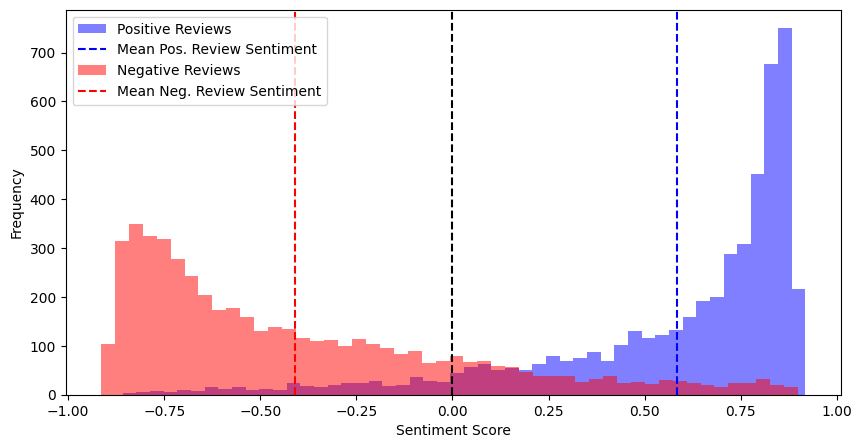

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(data_A["sentiment_score"].values, bins=50, alpha=0.5, label='Positive Reviews', color='blue')
plt.axvline(x=data_A["sentiment_score"].mean(), color='blue', linestyle='--', label='Mean Pos. Review Sentiment')
plt.hist(data_B["sentiment_score"].values, bins=50, alpha=0.5, label='Negative Reviews', color='red')
plt.axvline(x=data_B["sentiment_score"].mean(), color='red', linestyle='--', label='Mean Neg. Review Sentiment')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_sentiment_score_frequency.pdf"), format="pdf", bbox_inches='tight')
plt.show()

### Prepare UMAP, Leiden and vectorizer model

In [13]:
umap_params = {
    'n_neighbors': 100,
    'min_dist': 0.0,
    'metric': 'cosine',
    'transform_mode': "embedding",
    'random_state': RANDOM_STATE
}

leiden_params = {
    'resolution': 1.5,
    'modularity': 'dugue',
    'random_state': RANDOM_STATE,
}

vectorizer_model = CountVectorizer(stop_words=STOP_WORDS, ngram_range=(1, 2), max_features=10000)

topol_model = TOPOL(
    n_components=50,
    umap_model_params=umap_params,
    leiden_model_params=leiden_params,
    vectorizer_model=vectorizer_model,
    supervised=True,
)

### Apply analysis

In [14]:
topol_model.apply_modeling(
    df_A=data_A,
    df_B=data_B,
    n_top_freq_words=20,
    n_repr_docs=10,
    n_top_tf_idf_words=20
)

/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP applied successfully.
Leiden clustering applied successfully.


/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['date', 'location', 'num', 'organization', 'time'] not in stop_words.
  warnings.warn(


Cluster information extracted successfully.


In [15]:
topol_model.dataset_A.cluster_info

,Cluster,Count,Top_Words,Centroid,2D_Centroid,Top_Representative_Docs,Top_Words_TFIDF
0,0,884,"{'album': 661, 'cd': 619, 'date': 470, 'num': ...","[0.010969975832860277, -0.00956266723154865, -...",-2.222857,[One of the best albums of DATE Set aside copy...,"{'cd': 0.41533197940001637, 'love': 0.16344568..."
1,1,694,"{'movie': 671, 'great': 335, 'date': 327, 'num...","[0.0021784249334913974, 0.026902751688362054, ...",-1.039042,[Tons of great content I don't know of anythin...,"{'date': 0.33217040304583484, 'movie': 0.31371..."
2,2,373,"{'num': 302, 'great': 222, 'good': 153, 'date'...","[-0.004446585214918497, -0.009332190847701824,...",5.418420,[Almost perfect I absolutely love this product...,"{'num': 0.28935142376257794, 'great': 0.254170..."
3,3,1050,"{'book': 1592, 'read': 794, 'date': 404, 'stor...","[0.009657198891817686, 0.0222100914977186, -0....",-2.035470,"[A MOST PLEASANT READ What a pleasure, in DATE...","{'book': 0.37228267938935167, 'read': 0.279212..."
4,4,119,"{'book': 198, 'read': 64, 'good': 44, 'num': 4...","[0.00632185865158265, 0.033157376474661736, -0...",-2.670837,[Sad to see all of these one-star ratings I th...,"{'book': 0.4738220342035632, 'read': 0.1930386..."
5,5,426,"{'date': 222, 'num': 205, 'great': 196, 'good'...","[0.015437497564280549, 0.0015342026699342991, ...",4.193992,[good value My daughter DATE (then six) got th...,"{'date': 0.3348668818076154, 'love': 0.2214793..."
6,6,457,"{'book': 861, 'great': 190, 'good': 181, 'date...","[-0.002962438681127103, 0.015316511131606536, ...",-1.154676,[Cool ! Easy to read and best of all - it all ...,"{'book': 0.5860261297231085, 'great': 0.274546..."
7,7,386,"{'num': 243, 'great': 215, 'date': 142, 'good'...","[-0.002964472832890931, -0.001609386387529935,...",5.720954,[nothing like a quality utensil! I works as ad...,"{'great': 0.14610810787799305, 'like': 0.14610..."
8,8,148,"{'date': 97, 'great': 83, 'product': 77, 'num'...","[0.0035111068909581926, -0.006961766025523428,...",5.136829,"[Amazing! I love this stuff, my husband bought...","{'date': 0.2386273347232497, 'hair': 0.2169339..."
9,9,37,"{'num': 35, 'kindle': 31, 'book': 16, 'great':...","[0.009091751814373088, 0.0025115503199599886, ...",1.901807,[DATE My thoughts after NUM months:- Worth eve...,"{'kindle': 0.5378799356602841, 'num': 0.182240..."


In [16]:
topol_model.dataset_B.cluster_info

,Cluster,Count,Top_Words,Centroid,2D_Centroid,Top_Representative_Docs,Top_Words_TFIDF
0,0,510,"{'cd': 310, 'album': 293, 'like': 272, 'music'...","[0.0043278797369709415, 0.006608367727305592, ...",-1.480400,[NUM well crafted songs does NOT make a great ...,"{'cd': 0.29479114175178583, 'songs': 0.2254285..."
1,1,634,"{'movie': 840, 'film': 306, 'num': 281, 'time'...","[-0.011022945965855267, 0.04285339257606064, -...",-1.420106,[What the hell did I just watch. I am a true B...,"{'movie': 0.40120476054626236, 'time': 0.16716..."
2,2,839,"{'num': 694, 'date': 664, 'product': 356, 'tim...","[-0.017050352715389346, 0.010483604183863028, ...",5.355025,[Worthless - Do NOT buy I read the other revie...,"{'date': 0.2529042645876224, 'time': 0.2107535..."
3,3,63,"{'book': 79, 'date': 29, 'read': 29, 'num': 19...","[0.0029053626940511758, 0.030450530631083345, ...",-2.324719,[Professional Editing makes ALL the difference...,"{'read': 0.2030918691851883, 'book': 0.2030918..."
4,4,923,"{'book': 1525, 'read': 574, 'just': 339, 'like...","[0.00217499634923997, 0.040034343658289395, -0...",-2.968990,[Couldn't even finish it I couldn't get past p...,"{'book': 0.4448866660896023, 'read': 0.2607956..."
5,5,529,"{'date': 277, 'num': 276, 'product': 155, 'tim...","[0.0014362857555359314, 0.018333980590206564, ...",4.457185,[Dissappointed- toy not designed well I bought...,"{'date': 0.37679873957290927, 'num': 0.1883993..."
6,6,493,"{'book': 965, 'num': 258, 'information': 138, ...","[-0.009222774204930308, 0.0248857992228369, -0...",-1.313219,[Does not deliver what it promises I was disco...,"{'book': 0.6723928473299418, 'waste': 0.107389..."
7,7,368,"{'num': 211, 'date': 207, 'time': 118, 'use': ...","[-0.01812646485379703, 0.022404795011504535, -...",5.796368,[An adjustable disappointment When I first got...,"{'water': 0.2263859782613562, 'date': 0.221478..."
8,8,146,"{'product': 92, 'date': 63, 'like': 60, 'just'...","[-0.012065670893556273, 0.006749616108383435, ...",5.366138,[Not as advertised and reviewed After searchin...,"{'product': 0.3756674835345824, 'hair': 0.2504..."
9,9,252,"{'num': 278, 'date': 110, 'product': 85, 'amaz...","[-0.004683324110662816, 0.0070880472359267374,...",3.221510,[Big Disappointment!!! Ordered the Verbatim NU...,"{'num': 0.33508940235441365, 'dvd': 0.20105364..."


Drift computed successfully, ready to vizualize.


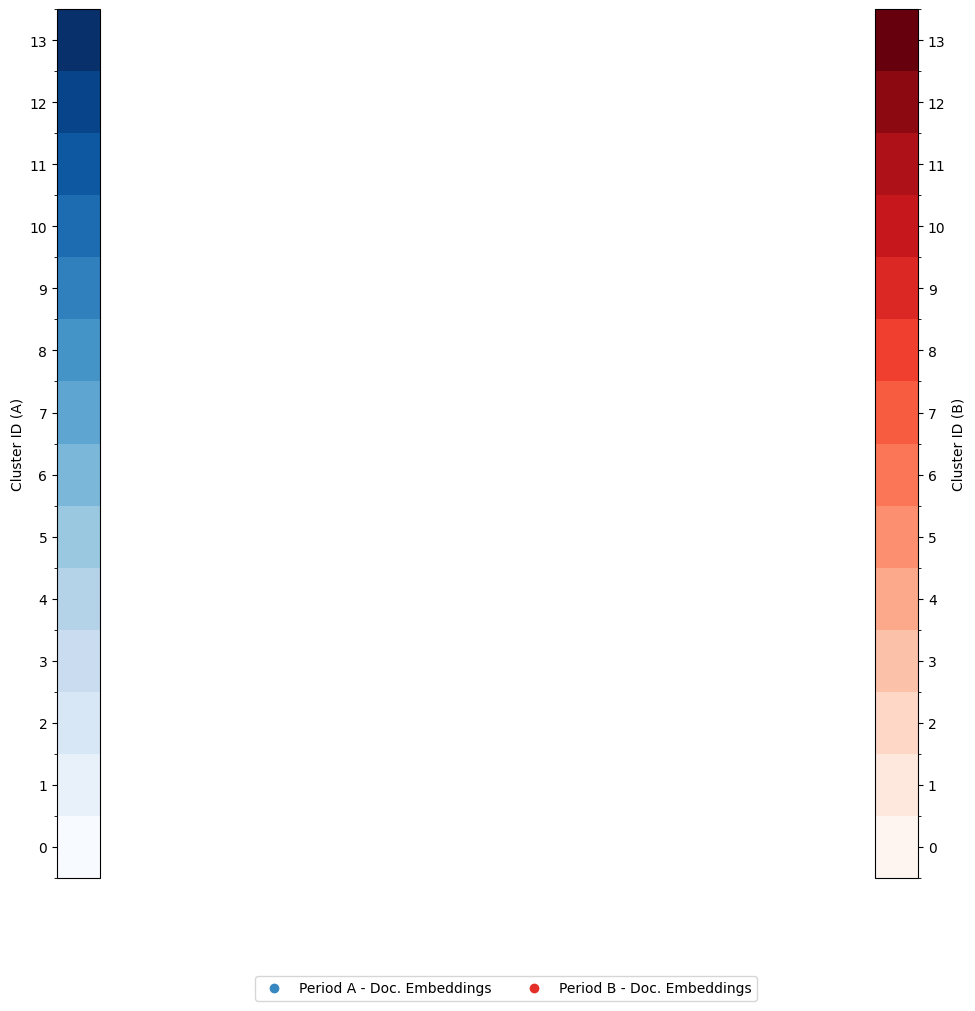

In [17]:
fig, ax = topol_model.vizualize_clusters()
# fig.write_image(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_topol_clusters.pdf"), format="pdf", bbox_inches='tight')
fig.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_topol_clusters.pdf"), format="pdf", bbox_inches='tight')
# plt.show(fig, ax)

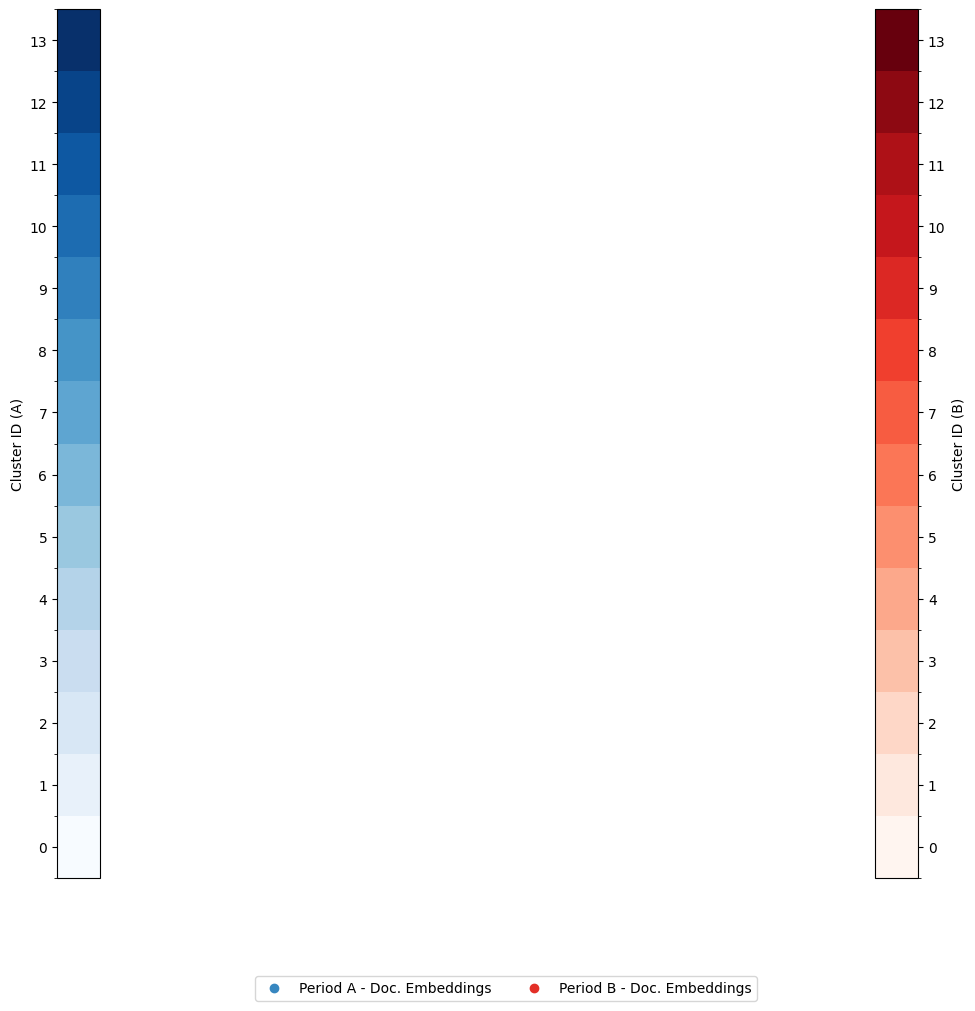

In [18]:
from IPython.display import display
display(fig)

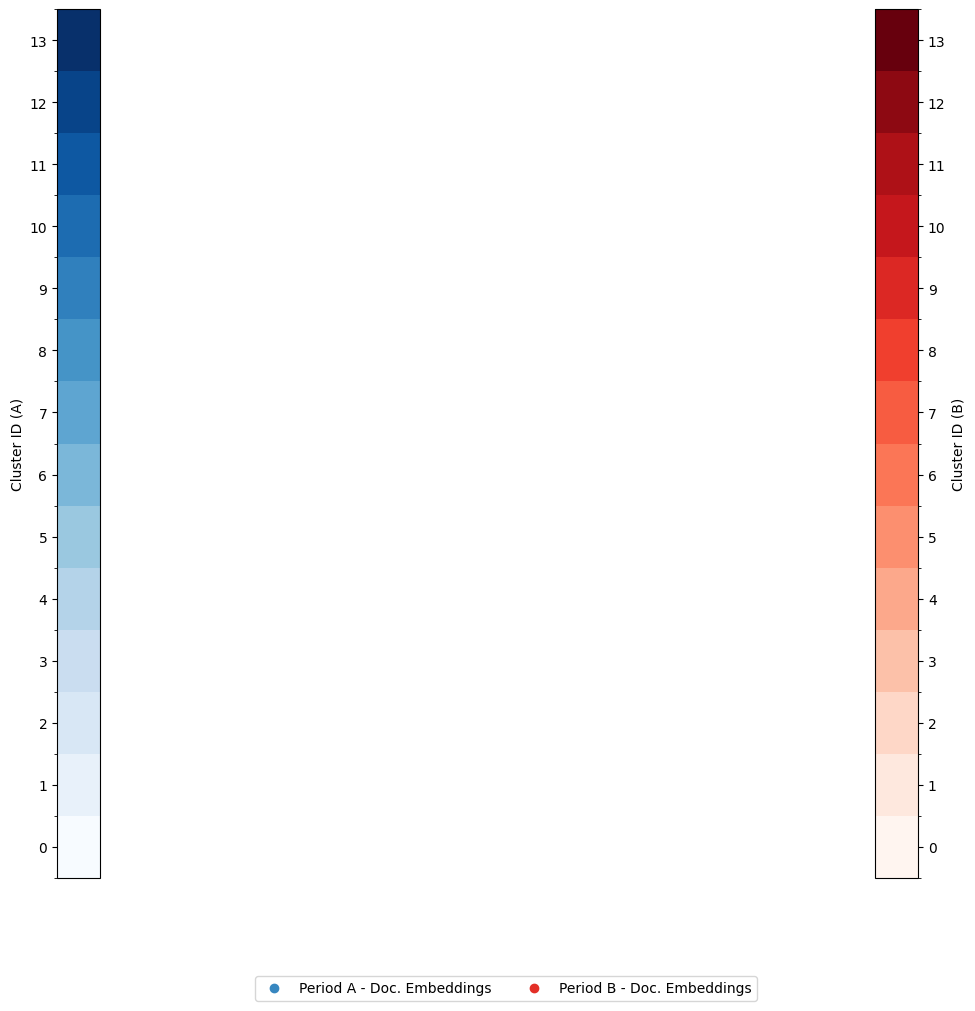

In [19]:
ax.get_figure()

In [ ]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'brown', 'gray']
drifts_df = pd.DataFrame.from_dict(topol_model.drifts, orient='index', columns=['x', 'y']).dropna()
drifts_df.index.name = "Cluster"

fig, ax = plt.subplots(figsize=(8, 10))

for topic_id, row in drifts_df.iterrows():
    x, y, label_id = row['x'], row['y'], int(row['labels'])
    color = colors[label_id]
    ax.plot([0, x], [0, y], color=color, linewidth=2, label=f"Topic {topic_id}")
    ax.text(x, y, f"Topic {topic_id}", fontsize=9, color=color, ha='left', va='bottom')

lim = 2.1
ax.set_aspect('equal', 'box')
ax.set_xlim(-lim, lim); ax.set_ylim(-lim, lim)
ax.axhline(0, color='black', linewidth=0.5); ax.axvline(0, color='black', linewidth=0.5)
ax.set_frame_on(False)
fig.tight_layout()

fig.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_topol_drifts.pdf"), format="pdf", bbox_inches='tight')
plt.show()